### Import models and load data

In [1]:
from torchvision import datasets
import torch
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

# Import all models
from BaseNet import *
from ConvNet1 import *
#from NetSharing import *

mini_batch_size = 1000
nb_epochs = 300
nb_runs = 2
eta = 0.001

train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)

/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### 1channel2images

In [2]:
from importlib import reload
import _1channel2images
reload(_1channel2images)
from _1channel2images import *

print("Working with 1channel2images framework, nb_classes = ", nb_classes)

#model = BaseNet1C(nb_classes)
model_1C = ConvNet1_1C(nb_classes)
optimizer_1C = torch.optim.SGD(model_1C.parameters(), lr=eta, momentum=0.95)
test_results_1C = multiple_training_runs(model_1C, 2, optimizer_1C, train_input, train_classes,
                                      test_input, test_target, test_classes, mini_batch_size, nb_epochs)
write_to_csv('1channel2images.csv', model_1C, test_results_1C)

Working with 1channel2images framework, nb_classes =  10


KeyboardInterrupt: 

In [ ]:
# This is just for visualization of our results but it will have to be taken away for the report 
# since we can't use any additional libraries
import pandas as pd

print(test_results_1C)
write_to_csv('1channel2images.csv', model_1C, test_results_1C)
data = pd.read_csv('1channel2images.csv')
data.head()

### 2channels1image

In [ ]:
import _2channels1image
reload(_2channels1image)
from _2channels1image import *

print("Working with 2channels1image framework, nb_classes = ", nb_classes)

model_2C = ConvNet1_2C(nb_classes)
optimizer_2C = torch.optim.SGD(model_2C.parameters(), lr=0.00001, momentum=0.95)  
test_results_2C = multiple_training_runs(model_2C, 2, optimizer_2C, train_input, train_target,
                           test_input, test_target, mini_batch_size, nb_epochs)
write_to_csv('2channels1image.csv', model_2C, test_results_2C)

In [ ]:
print(test_results_2C)
write_to_csv('2channels1image.csv', model_2C, test_results_2C)
data = pd.read_csv('2channels1image.csv')
data.head()

### Weight Sharing

In [ ]:
import weight_sharing
reload(weight_sharing)
from weight_sharing import *

print("Working with weight_sharing framework")

model_ws = NetSharing1()
optimizer_ws = torch.optim.SGD(model_ws.parameters(), lr=0.00001, momentum=0.95)  
test_results_ws = multiple_training_runs(model_ws, nb_runs, optimizer_ws, train_input, train_target,
                           test_input, test_target, mini_batch_size, nb_epochs)
write_to_csv('weightsharing.csv', model_ws, test_results_ws)

In [ ]:
print(test_results_ws)
write_to_csv('weightsharing.csv', model_ws, test_results_ws)
data = pd.read_csv('weightsharing.csv')
data.head()

### Auxiliary Losses

In [ ]:
import auxiliary_losses
reload(auxiliary_losses)
from auxiliary_losses import *
import Incept1
reload(Incept1)
from Incept1 import *
nb_epochs = 300
print("Working with auxiliary losses framework")

model_aux = Incept1()
optimizer_aux = torch.optim.SGD(model_aux.parameters(), lr=0.00001, momentum=0.95)  
test_results_aux = multiple_training_runs(model_aux, nb_runs, optimizer_aux, train_input, train_target, train_classes, 
                                          test_input, test_target, test_classes, mini_batch_size, nb_epochs)
write_to_csv('auxiliary_losses.csv', model_aux, test_results_aux)

In [ ]:
print(test_results_aux)
write_to_csv('auxiliary_losses.csv', model_aux, test_results_aux)
data = pd.read_csv('auxiliary_losses.csv')
data.head()

## Weight Sharing and Auxiliary Loss Models(Youssef)

In [14]:
print(train_input.shape, train_target.shape, train_classes.shape, test_input.shape, test_target.shape, test_classes.shape)

torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2]) torch.Size([1000, 2, 14, 14]) torch.Size([1000]) torch.Size([1000, 2])


In [15]:
from torch.autograd import Variable
from WSharingModel import *
from torch import nn, optim
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
import torch
from torchvision import datasets
from torch import optim
import dlc_practical_prologue as prologue
from AuxModel import *
from torch.autograd import Variable
from torch.nn import functional as F


#### Function that draws the evolution of the loss during training.

In [16]:
def visualize_loss(model,loss_model,lr):
    plt.plot(loss_model[0],loss_model[1], color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evolution of the loss during training with learning rate {:>5} of the model {:>5}.'.format(lr,model.__class__.__name__))
    plt.show()

#### Function that prints the results of the prediction one the model is trained.

In [17]:
def print_results(model,optimizer,learning_rate,NB_EPOCHS,MINI_BATCH_SIZE, train_input, train_target,test_input, test_target):
     print('model: {:6}, optimizer: {:6}, learning rate: {:6}, num epochs: {:3}, '
                    'mini batch size: {:3}, train error: {:5.2f}%, test error: {:5.2f}%'.format(
                    model.__class__.__name__,
                    optimizer.__name__,
                    learning_rate,
                    NB_EPOCHS,
                    MINI_BATCH_SIZE,
                    model.compute_nb_errors(model, train_input, train_target, MINI_BATCH_SIZE) / train_input.size(0) * 100,
                    model.compute_nb_errors(model, test_input, test_target, MINI_BATCH_SIZE) / test_input.size(0) * 100
                    )
                )

### Treatement of our Training and Testing Data.

In [18]:
# normalize it
mean, std = train_input.mean(), train_input.std() 
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes)
test_input, test_target = Variable(test_input), Variable(test_target)

### We define our Learning parameters.

In [19]:
NB_EPOCHS = 50
MINI_BATCH_SIZE = 100
learning_rates = [0.1, 0.01]

### We define our optimizers and losses and weights for the auxiliary losses.

In [20]:
op = torch.optim.SGD
losses = [CrossEntropyLoss(),BCEWithLogitsLoss()]
alpha = 0.5
beta = 1

### Training of Different Models and Results on Training and Testing set.

Loss at epoch   0 : 1.5931733846664429  
Loss at epoch   1 : 1.1708143949508667  
Loss at epoch   2 : 0.7579388618469238  
Loss at epoch   3 : 0.7059504985809326  
Loss at epoch   4 : 0.7623346447944641  
Loss at epoch   5 : 0.5767707228660583  
Loss at epoch   6 : 0.5058138966560364  
Loss at epoch   7 : 0.42225730419158936  
Loss at epoch   8 : 0.4457586705684662  
Loss at epoch   9 : 0.4232325851917267  
Loss at epoch  10 : 0.5001781582832336  
Loss at epoch  11 : 0.42033275961875916  
Loss at epoch  12 : 0.3651975393295288  
Loss at epoch  13 : 0.3247389495372772  
Loss at epoch  14 : 0.293742299079895  
Loss at epoch  15 : 0.2702767550945282  
Loss at epoch  16 : 0.27155348658561707  
Loss at epoch  17 : 0.24890632927417755  
Loss at epoch  18 : 0.2271142154932022  
Loss at epoch  19 : 0.2184830605983734  
Loss at epoch  20 : 0.21102797985076904  
Loss at epoch  21 : 0.22996455430984497  
Loss at epoch  22 : 0.1652825027704239  
Loss at epoch  23 : 0.15454678237438202  
Loss at ep

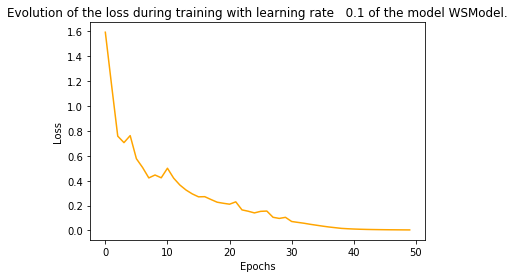

Loss at epoch   0 : 1.0608984231948853  
Loss at epoch   1 : 0.7432945966720581  
Loss at epoch   2 : 0.7028694748878479  
Loss at epoch   3 : 0.6870779395103455  
Loss at epoch   4 : 0.6783639788627625  
Loss at epoch   5 : 0.674052357673645  
Loss at epoch   6 : 0.6730619668960571  
Loss at epoch   7 : 0.6743618249893188  
Loss at epoch   8 : 0.6753957867622375  
Loss at epoch   9 : 0.672397792339325  
Loss at epoch  10 : 0.6667134165763855  
Loss at epoch  11 : 0.6602374911308289  
Loss at epoch  12 : 0.6534301042556763  
Loss at epoch  13 : 0.6456688046455383  
Loss at epoch  14 : 0.6356527209281921  
Loss at epoch  15 : 0.6270893812179565  
Loss at epoch  16 : 0.6166854500770569  
Loss at epoch  17 : 0.6053372025489807  
Loss at epoch  18 : 0.5934202075004578  
Loss at epoch  19 : 0.5801225900650024  
Loss at epoch  20 : 0.568310558795929  
Loss at epoch  21 : 0.5563148856163025  
Loss at epoch  22 : 0.5437567830085754  
Loss at epoch  23 : 0.5315165519714355  
Loss at epoch  24 :

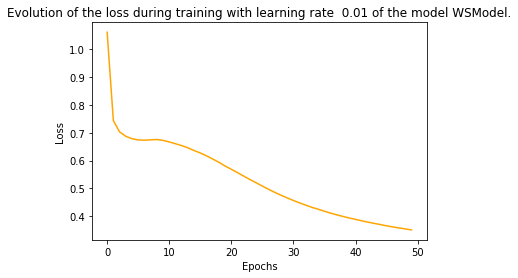

Loss at epoch   0 : 0.6606205105781555  
Loss at epoch   1 : 0.6203162670135498  
Loss at epoch   2 : 0.7911128997802734  
Loss at epoch   3 : 0.4439166188240051  
Loss at epoch   4 : 0.3937903940677643  
Loss at epoch   5 : 0.3816970884799957  
Loss at epoch   6 : 0.3402155339717865  
Loss at epoch   7 : 0.31741446256637573  
Loss at epoch   8 : 0.3029659688472748  
Loss at epoch   9 : 0.2839077413082123  
Loss at epoch  10 : 0.2752622365951538  
Loss at epoch  11 : 0.252876877784729  
Loss at epoch  12 : 0.2407764494419098  
Loss at epoch  13 : 0.23648938536643982  
Loss at epoch  14 : 0.20429807901382446  
Loss at epoch  15 : 0.23529906570911407  
Loss at epoch  16 : 0.17312496900558472  
Loss at epoch  17 : 0.18991559743881226  
Loss at epoch  18 : 0.15442973375320435  
Loss at epoch  19 : 0.14539651572704315  
Loss at epoch  20 : 0.13000892102718353  
Loss at epoch  21 : 0.13646411895751953  
Loss at epoch  22 : 0.11265291273593903  
Loss at epoch  23 : 0.09699097275733948  
Loss 

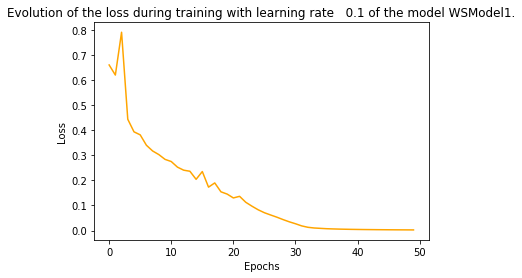

Loss at epoch   0 : 0.6894112229347229  
Loss at epoch   1 : 0.6826723217964172  
Loss at epoch   2 : 0.6760300993919373  
Loss at epoch   3 : 0.6686152815818787  
Loss at epoch   4 : 0.6609519720077515  
Loss at epoch   5 : 0.6526759266853333  
Loss at epoch   6 : 0.6439467668533325  
Loss at epoch   7 : 0.6345562934875488  
Loss at epoch   8 : 0.6240724325180054  
Loss at epoch   9 : 0.612880289554596  
Loss at epoch  10 : 0.6010222434997559  
Loss at epoch  11 : 0.5885064601898193  
Loss at epoch  12 : 0.5751845240592957  
Loss at epoch  13 : 0.5614412426948547  
Loss at epoch  14 : 0.5473238229751587  
Loss at epoch  15 : 0.5329775810241699  
Loss at epoch  16 : 0.5186456441879272  
Loss at epoch  17 : 0.504377543926239  
Loss at epoch  18 : 0.49048736691474915  
Loss at epoch  19 : 0.47717493772506714  
Loss at epoch  20 : 0.4645223915576935  
Loss at epoch  21 : 0.4527152180671692  
Loss at epoch  22 : 0.4418201744556427  
Loss at epoch  23 : 0.4316849112510681  
Loss at epoch  2

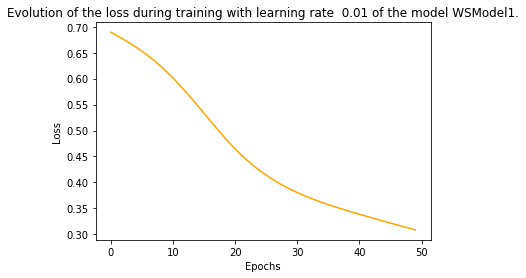

Loss at   0 : 4.885939121246338  
Loss at   1 : 4.529895782470703  
Loss at   2 : 4.693931579589844  
Loss at   3 : 4.658938407897949  
Loss at   4 : 3.7193286418914795  
Loss at   5 : 3.6792984008789062  
Loss at   6 : 3.274841785430908  
Loss at   7 : 1.9920591115951538  
Loss at   8 : 2.135071039199829  
Loss at   9 : 2.4936609268188477  
Loss at  10 : 1.4316513538360596  
Loss at  11 : 0.9083067178726196  
Loss at  12 : 0.7338847517967224  
Loss at  13 : 0.5696123242378235  
Loss at  14 : 0.4917108714580536  
Loss at  15 : 0.544126570224762  
Loss at  16 : 0.4467204213142395  
Loss at  17 : 0.3895251750946045  
Loss at  18 : 0.3541269898414612  
Loss at  19 : 1.4231921434402466  
Loss at  20 : 0.4203462600708008  
Loss at  21 : 0.35661423206329346  
Loss at  22 : 0.30297911167144775  
Loss at  23 : 0.2257792353630066  
Loss at  24 : 0.18324607610702515  
Loss at  25 : 0.1564132571220398  
Loss at  26 : 0.14122174680233002  
Loss at  27 : 0.12772317230701447  
Loss at  28 : 0.119438

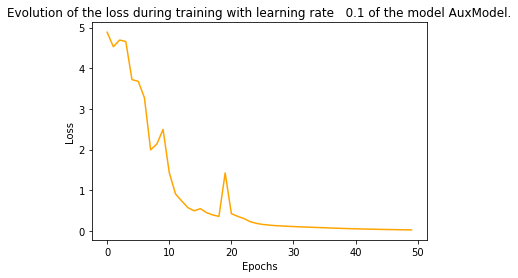

Loss at   0 : 4.927739143371582  
Loss at   1 : 4.92047119140625  
Loss at   2 : 4.91256856918335  
Loss at   3 : 4.903417587280273  
Loss at   4 : 4.8939738273620605  
Loss at   5 : 4.882934093475342  
Loss at   6 : 4.868405342102051  
Loss at   7 : 4.852033615112305  
Loss at   8 : 4.83355712890625  
Loss at   9 : 4.81378698348999  
Loss at  10 : 4.791791915893555  
Loss at  11 : 4.766241073608398  
Loss at  12 : 4.736403465270996  
Loss at  13 : 4.702094078063965  
Loss at  14 : 4.662283420562744  
Loss at  15 : 4.61538553237915  
Loss at  16 : 4.559099197387695  
Loss at  17 : 4.49118709564209  
Loss at  18 : 4.413135051727295  
Loss at  19 : 4.323252201080322  
Loss at  20 : 4.223078727722168  
Loss at  21 : 4.115723133087158  
Loss at  22 : 4.00433349609375  
Loss at  23 : 3.8901758193969727  
Loss at  24 : 3.7719266414642334  
Loss at  25 : 3.652087688446045  
Loss at  26 : 3.55368971824646  
Loss at  27 : 3.5801920890808105  
Loss at  28 : 3.420305013656616  
Loss at  29 : 3.31

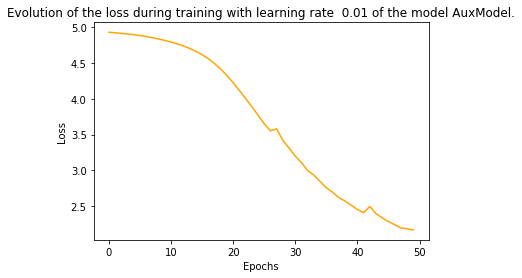

Loss at   0 : 4.621102333068848  
Loss at   1 : 4.225714206695557  
Loss at   2 : 3.1464242935180664  
Loss at   3 : 2.532541036605835  
Loss at   4 : 2.3513927459716797  
Loss at   5 : 1.770032286643982  
Loss at   6 : 1.241991400718689  
Loss at   7 : 1.0907292366027832  
Loss at   8 : 1.1049721240997314  
Loss at   9 : 0.8816272616386414  
Loss at  10 : 0.8484655618667603  
Loss at  11 : 0.7934935092926025  
Loss at  12 : 0.7481510043144226  
Loss at  13 : 0.7071205973625183  
Loss at  14 : 0.6812518835067749  
Loss at  15 : 0.6849319338798523  
Loss at  16 : 0.6499795913696289  
Loss at  17 : 0.6325887441635132  
Loss at  18 : 0.61622554063797  
Loss at  19 : 0.6036076545715332  
Loss at  20 : 0.5946261286735535  
Loss at  21 : 0.584135890007019  
Loss at  22 : 0.5754901766777039  
Loss at  23 : 0.5625455379486084  
Loss at  24 : 0.5562440752983093  
Loss at  25 : 0.5464500188827515  
Loss at  26 : 0.5389575958251953  
Loss at  27 : 0.5329303741455078  
Loss at  28 : 0.539677023887

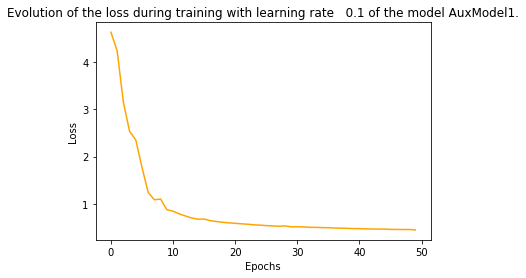

Loss at   0 : 4.873674392700195  
Loss at   1 : 4.797917366027832  
Loss at   2 : 4.715977191925049  
Loss at   3 : 4.6219964027404785  
Loss at   4 : 4.512242317199707  
Loss at   5 : 4.381453037261963  
Loss at   6 : 4.229177474975586  
Loss at   7 : 4.055629730224609  
Loss at   8 : 3.8667216300964355  
Loss at   9 : 3.667390823364258  
Loss at  10 : 3.4637112617492676  
Loss at  11 : 3.26324725151062  
Loss at  12 : 3.0744988918304443  
Loss at  13 : 2.9001362323760986  
Loss at  14 : 2.7415008544921875  
Loss at  15 : 2.6019160747528076  
Loss at  16 : 2.477271556854248  
Loss at  17 : 2.3690922260284424  
Loss at  18 : 2.272007465362549  
Loss at  19 : 2.1903862953186035  
Loss at  20 : 2.1139779090881348  
Loss at  21 : 2.044996500015259  
Loss at  22 : 1.9827837944030762  
Loss at  23 : 1.9256436824798584  
Loss at  24 : 1.8686915636062622  
Loss at  25 : 1.8187382221221924  
Loss at  26 : 1.773931860923767  
Loss at  27 : 1.7333918809890747  
Loss at  28 : 1.6944096088409424  

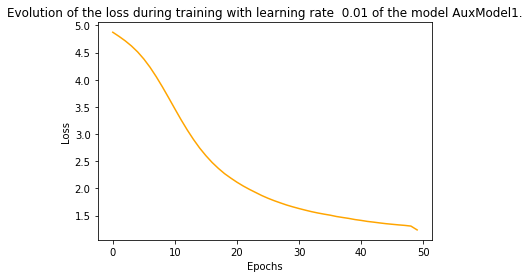

In [22]:
 for j in range(4):
        for i in range(len(learning_rates)):
            models = [WSModel(),WSModel1(),AuxModel(),AuxModel1()]
            model = models[j]
            optimizer = op(model.parameters(),lr = learning_rates[i])
            if (j<2):
                #print("here")
                loss_aux = train_model_WS(model, optimizer,  train_input, train_target, NB_EPOCHS, MINI_BATCH_SIZE,losses[0])
            elif(j>1):
                #print("here here")
                loss_aux = train_model_AM(model, optimizer,  train_input, train_target, train_classes,NB_EPOCHS, MINI_BATCH_SIZE,losses[0],alpha,beta)
            #print("model:",model)
            print_results(model,op,learning_rates[i],NB_EPOCHS,MINI_BATCH_SIZE, train_input, train_target,test_input, test_target)
            visualize_loss(model,loss_aux,learning_rates[i])